In [28]:
from functools import partial
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.envs.original import Pendulum 
from src.envs.realistic import RealisticPendulum 
from src.dyn_model.Predict import pretrained_params




In [29]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [30]:
env = Pendulum.Pendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [31]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

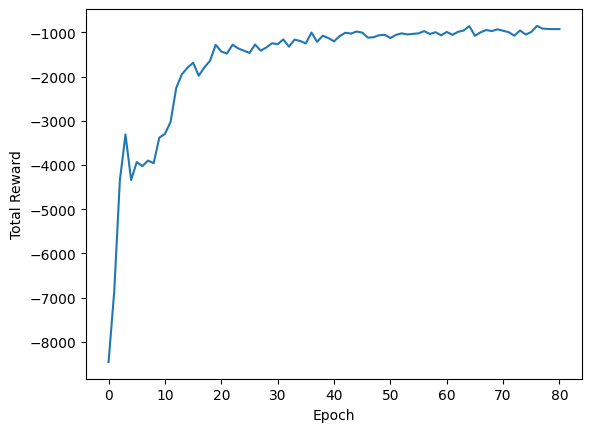

In [32]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train_hds(env,trajectory_length=100 ,num_samples=100,epochs=20, inner_epochs=20, alpha_a=5e-6, aggregation_factor_beta=0.0,init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.0, progress_fn=progress_f) 
# policy = train_pods(env,trajectory_length=100 ,num_samples=100,epochs=20, inner_epochs=20, alpha_a=8e-5, init_learning_rate=1e-3, progress_fn=progress_f)

In [ ]:
realistic_env = RealisticPendulum.RealisticPendulum()
inference_fn = policy()

@partial(jax.vmap, in_axes=(None, None, None, 0), axis_name="batch")
def rollout_policy(
        env, inference_fn, trajectory_length: int, prng_keys
    ):

    def step_trajectory(state_carry, rng_key):
        action = inference_fn(state_carry.obs)
        next_state = env.step(state_carry, action)
        return next_state, (state_carry.obs, action, next_state.reward, state.pipeline_state)

    state = env.reset(prng_keys)
    keys = jax.random.split(prng_keys, trajectory_length)
    _, (states, actions, rewards_future, pipeline_states) = jax.lax.scan(
        step_trajectory, state, xs=keys
    )

    states = jax.numpy.reshape(
        states, (trajectory_length, env.observation_size)
    )
    actions = jax.numpy.reshape(
        actions, (trajectory_length, env.action_size)
    )

    totalreward = jp.sum(rewards_future)

    return states, actions, totalreward, pipeline_states

prng_key = jax.random.PRNGKey(seed=0)
subkeys = jax.random.split(prng_key, num=100)

_, _ , rewards_original, rollout_original = rollout_policy(env, inference_fn, 100, subkeys)
_, _ , rewards_realistic, rollout_realistic = rollout_policy(realistic_env, inference_fn, 100, subkeys)

average_reward_original = jp.mean(rewards_original)
average_reward_realistic = jp.mean(rewards_realistic)

In [ ]:
print(f'realistic {jp.mean(jp.array(average_reward_realistic))}')
print(f'original {jp.mean(jp.array(average_reward_original))}')

realistic -4658.729412806494
original -1546.910647106789


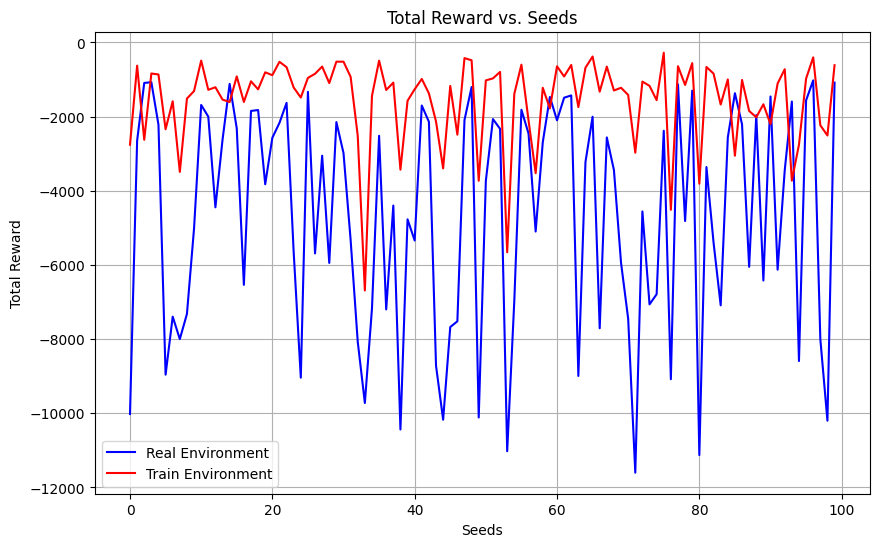

In [ ]:
seeds = [x for x in range(100)]
plt.figure(figsize=(10, 6))
plt.plot(seeds, rewards_realistic, label='Real Environment', color='blue')
plt.plot(seeds, rewards_original, label='Train Environment', color='red')
plt.xlabel('Seed')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Seeds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

yes=html.render(env.sys.replace(dt=env.dt), rollout_original)
with open("data.html", "w") as file:
    file.write(yes)

NameError: name 'rollout' is not defined